In [1]:
ZONE = "south"

In [2]:
%matplotlib inline

import sys
import os
from pathlib import Path
from datetime import datetime, timedelta
from collections import defaultdict

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tsd
import geojson
import json
import folium
import rasterio, rasterio.mask
from PIL import Image, ImageDraw, ImageFont

sys.path.append("../forestry_yield_estimation")
import vistools, utils
from preprocessing import get_timeseries, read_raw_points_data, read_raw_polygons_data, get_aoi, get_catalog, read_images

pd.options.mode.chained_assignment = None
plt.style.use("ggplot")
sns.set_context("notebook", font_scale=1.4)

root = Path("..")
data_path = root / "data"
output_path = Path("../report/img")

In [3]:
df = read_raw_points_data(data_path).query("zone == @ZONE")

In [4]:
# Normalization
montenativo = (
    pd.read_csv(data_path/"montenativo.csv")
    .rename(columns=lambda col: f"montenativo_{col.split('_')[0]}" if "backscatter" in col else col)
)

In [5]:
catalog = get_catalog(data_path, ZONE, download_crops=False)
catalog["date_str"] = catalog["date"].dt.date.astype("str")
montenativo = montenativo.merge(
    catalog,
    left_on=["date", "polarisation"], 
    right_on=["date_str", "polarisation"],
    suffixes=(None, "_y")
)[["date", "polarisation", "montenativo_mean", "montenativo_median", "filename"]]
montenativo = montenativo.reset_index(drop=True)
montenativo["date"] = pd.to_datetime(montenativo["date"])
montenativo

Found 76 images


,date,polarisation,montenativo_mean,montenativo_median,filename
0,2017-01-04,vh,2.787501,4.521789,2017-01-04_S1B_orbit_170_D_GRD_vh
1,2017-01-04,vv,3.109831,5.068904,2017-01-04_S1B_orbit_170_D_GRD_vv
2,2017-01-16,vh,2.742425,4.442651,2017-01-16_S1B_orbit_170_D_GRD_vh
3,2017-01-16,vv,3.082079,5.010635,2017-01-16_S1B_orbit_170_D_GRD_vv
4,2017-01-28,vh,2.622059,4.219508,2017-01-28_S1B_orbit_170_D_GRD_vh
...,...,...,...,...,...
117,2018-12-01,vv,3.033990,4.941642,2018-12-01_S1B_orbit_170_D_GRD_vv
118,2018-12-13,vh,2.667043,4.276666,2018-12-13_S1B_orbit_170_D_GRD_vh
119,2018-12-13,vv,3.041726,4.934474,2018-12-13_S1B_orbit_170_D_GRD_vv
120,2018-12-25,vh,2.689327,4.356709,2018-12-25_S1B_orbit_170_D_GRD_vh


In [6]:
raw_images, filenames, srcs = read_images(data_path, ZONE)
assert list(filenames) == montenativo["filename"].tolist()

images = np.log(raw_images)
is_vv = np.array([f.endswith("vv") for f in filenames])

norm = montenativo["montenativo_mean"].values
images = images - norm.reshape(-1, 1, 1)

images_8bit = np.empty_like(images, dtype="uint8")
images_8bit[is_vv] = utils.simple_equalization_8bit(images[is_vv])
images_8bit[~is_vv] = utils.simple_equalization_8bit(images[~is_vv])

  0%|          | 0/122 [00:00<?, ?it/s]

In [8]:
df["date"]

0     2016-06-18
1     2016-06-18
2     2013-06-08
3     2016-06-18
4     2016-06-18
         ...    
469   2017-10-06
470   2017-03-04
471   2017-03-04
472   2017-03-10
473   2017-03-10
Name: date, Length: 474, dtype: datetime64[ns]

In [21]:
window_size_time = timedelta(days=90)
window_size_space = 1
offset_correction=(-40, 20)

measurements = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    # Time window selection
    current_date = row["date"]
    indices = montenativo.loc[(montenativo["date"] < current_date + window_size_time/2) & (montenativo["date"] > current_date - window_size_time/2), "date"].index.tolist()
    #indices = montenativo.loc[(montenativo["date"] < current_date), "date"].index.tolist()
    if len(indices) == 0:
        measurements.append(defaultdict(lambda : np.nan))
        continue
    
    # Space selection
    coords = srcs[0].index(row["easting"] + offset_correction[0], row["northing"] + offset_correction[1])
    window = (
        int(coords[0] - window_size_space/2),
        int(coords[0] + window_size_space/2),
        int(coords[1] - window_size_space/2),
        int(coords[1] + window_size_space/2),
    )
    
    # Extract measurements
    windows = images[indices, window[0]:window[1], window[2]:window[3]]
    vh, vv = windows[~is_vv[indices]], windows[is_vv[indices]]
    measurements.append({
        "measurement": np.median(vh - vv),
        "std": np.std(vh - vv),
    })
    
    #out = []
    #for date in dates:
    #    indices = montenativo.query("date == @date").index
    #    assert len(indices) == 2
    #    assert not is_vv[indices[0]]
    #    vh_window, vv_window = (
    #        images[index][window[0]:window[1], window[2]:window[3]]
    #        for index in indices
    #    )
    #    ratio = vh_window - vv_window
    #    out.append(ratio.flatten())
    
measurements = pd.DataFrame(measurements)
df[measurements.columns] = measurements

  0%|          | 0/474 [00:00<?, ?it/s]

/home/nathra/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nathra/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nathra/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/nathra/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/nathra/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


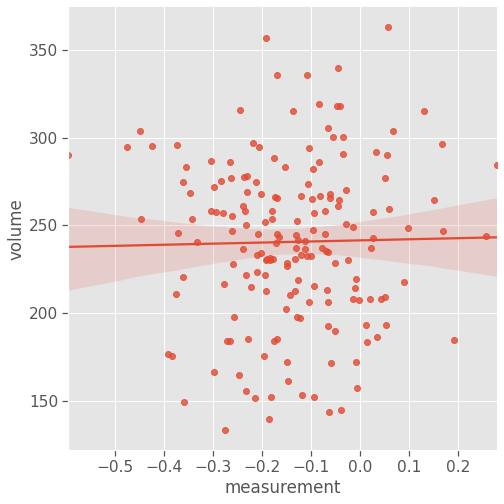

In [22]:
sns.lmplot(data=df, x="measurement", y="volume", height=7)
plt.savefig(output_path/"volume_prediction"/"tree_scale.png")

In [16]:
from scipy import stats
stats.linregress(df.dropna().measurement, df.dropna().volume)

LinregressResult(slope=31.437064845240133, intercept=244.96505760967918, rvalue=0.0559840539476316, pvalue=0.46181021771910147, stderr=42.62583906542285, intercept_stderr=6.911168923480847)